<a href="https://colab.research.google.com/github/Ash100/MDS/blob/main/SSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solvent-Accessible Surface Area (SASA) analysis

This notebook is designed by **Dr. Ashfaq Ahmad**, and can be used for research purposes. To watch a complete video demonstration, [click here](https://youtu.be/nKOb3MT5sMo)

We will perform these analysis using AmberTools.

Citation: https://pubs.acs.org/doi/10.1021/acs.jcim.3c01153

In [2]:
#@title setting the environment
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [3]:
#@title install AmberTools
!conda install -y -c conda-forge ambertools

\ | / done
Solving environment: \ | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.5.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [4]:
#@title Install pytraj
!pip install -q pytraj

In [5]:
#@title connect you Gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
import pytraj as pt

# Example paths
dcd_path = "/content/drive/MyDrive/Giezam/95424080-R/95424080-R_prod1-10_whole.dcd"
pdb_path = "/content/drive/MyDrive/Giezam/95424080-R/95424080-R_equil.pdb"

# Load trajectory
traj = pt.load(dcd_path, top=pdb_path)

### Generating SASA.in file is not that simple to click. It needs a proper probing of ligand residue present in your complex. How to probe ligand effectively? For complete detail, [watch here](https://youtu.be/nKOb3MT5sMo)

In [47]:
#@title writing sasa.in file
%%writefile cpptraj_sasa.in
parm /content/drive/MyDrive/Giezam/95424080-R/95424080-R_equil.pdb

# Load full system trajectory (protein + ligand + solvent)
trajin /content/drive/MyDrive/Giezam/95424080-R/95424080-R_prod1-10_whole.dcd
strip @H=
surf complex_sasa out complex_sasa.dat
run
clear all

# Protein only (residues 1 to 487)
parm /content/drive/MyDrive/Giezam/95424080-R/95424080-R_equil.pdb
trajin /content/drive/MyDrive/Giezam/95424080-R/95424080-R_prod1-10_whole.dcd
strip !:1-293
strip @H=
trajout protein.dcd
trajout protein.pdb pdb
run
clear all

parm protein.pdb
trajin protein.dcd
surf protein_sasa out protein_sasa.dat
run
clear all

# Ligand only (residue 404)
parm /content/drive/MyDrive/Giezam/95424080-R/95424080-R_equil.pdb
trajin /content/drive/MyDrive/Giezam/95424080-R/95424080-R_prod1-10_whole.dcd
strip !:294
strip @H=
trajout ligand.dcd
trajout ligand.pdb pdb
run
clear all

parm ligand.pdb
trajin ligand.dcd
surf ligand_sasa out ligand_sasa.dat
run

Writing cpptraj_sasa.in


In [48]:
#@title executing sasa.in in cpptraj
!cpptraj -i cpptraj_sasa.in



CPPTRAJ: Trajectory Analysis. V6.24.0 (AmberTools)
    ___  ___  ___  ___
     | \/ | \/ | \/ | 
    _|_/\_|_/\_|_/\_|_

| Date/time: 07/08/25 13:21:07
| Available memory: 981.783 MB

INPUT: Reading input from 'cpptraj_sasa.in'
  [parm /content/drive/MyDrive/Giezam/95424080-R/95424080-R_equil.pdb]
	Reading '/content/drive/MyDrive/Giezam/95424080-R/95424080-R_equil.pdb' as PDB File
	Reading bond info from CONECT records.
	Not reading bond info from LINK records.
	Determining bond info from distances.
  [trajin /content/drive/MyDrive/Giezam/95424080-R/95424080-R_prod1-10_whole.dcd]
	Reading '/content/drive/MyDrive/Giezam/95424080-R/95424080-R_prod1-10_whole.dcd' as Charmm DCD
	Symmetric shape matrix detected.
  [strip @H=]
    STRIP: Stripping atoms in mask [@H*]
  [surf complex_sasa out complex_sasa.dat]
    SURF: Calculating LCPO surface area for all solute atoms.
	Solute will be all molecules not marked as solvent with size > 1 atom.
	van der Waals offset is 1.4 Ang.
	Cutoff for dete

In [49]:
#@title validating lengths
import numpy as np

sasa_protein = np.loadtxt("protein_sasa.dat", usecols=1)
sasa_ligand = np.loadtxt("ligand_sasa.dat", usecols=1)
sasa_complex = np.loadtxt("complex_sasa.dat", usecols=1)

frames_protein = np.arange(len(sasa_protein))
frames_ligand = np.arange(len(sasa_ligand))
frames_complex = np.arange(len(sasa_complex))

print("Lengths:")
print(f"Protein SASA: {len(sasa_protein)}")
print(f"Ligand SASA: {len(sasa_ligand)}")
print(f"Complex SASA: {len(sasa_complex)}")


Lengths:
Protein SASA: 1000
Ligand SASA: 1000
Complex SASA: 1000


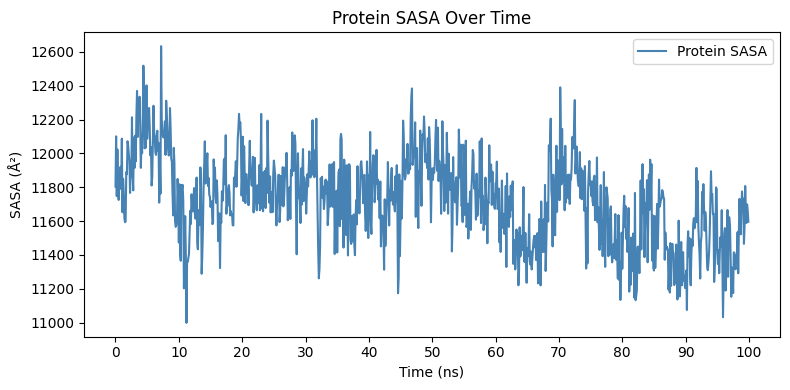

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Convert frame numbers to time in ns
time_ns = np.array(frames_protein) / 10  # Adjust if needed

plt.figure(figsize=(8, 4))
plt.plot(time_ns, sasa_protein, color='steelblue', label='Protein SASA')
plt.xlabel("Time (ns)")
plt.ylabel("SASA (Å²)")
plt.title("Protein SASA Over Time")
plt.xticks(np.arange(0, 110, 10))  # Set X-axis ticks
# plt.grid(True)  # <- Removed to avoid cross lines
plt.legend()
plt.tight_layout()
plt.savefig("/content/95424080R_protein.png", dpi=1200)
plt.show()


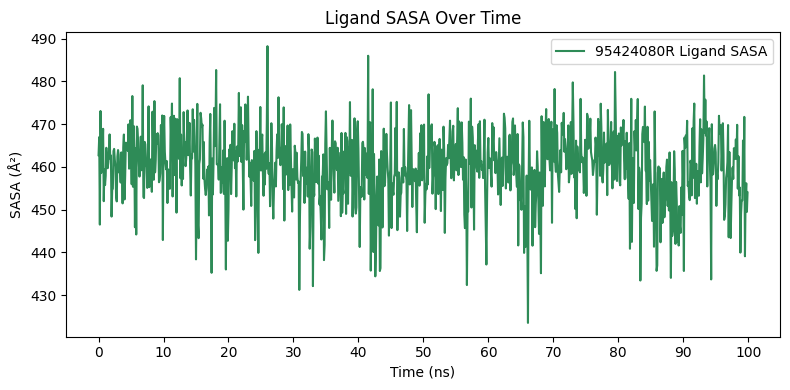

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Convert frame numbers to time (assuming stride = 10 → 1 frame = 0.1 ns)
time_ns = np.array(frames_ligand) / 10  # Adjust divisor if needed

plt.figure(figsize=(8, 4))
plt.plot(time_ns, sasa_ligand, color='seagreen', label='95424080R Ligand SASA')
plt.xlabel("Time (ns)")
plt.ylabel("SASA (Å²)")
plt.title("Ligand SASA Over Time")
plt.xticks(np.arange(0, 110, 10))  # X-axis ticks: 0, 10, ..., 100
# Grid removed
plt.legend()
plt.tight_layout()
plt.savefig("/content/95424080R_sasa.png", dpi=1200)
plt.show()

In [53]:
min_len = min(len(sasa_protein), len(sasa_ligand), len(sasa_complex))
bsa = sasa_protein[:min_len] + sasa_ligand[:min_len] - sasa_complex[:min_len]


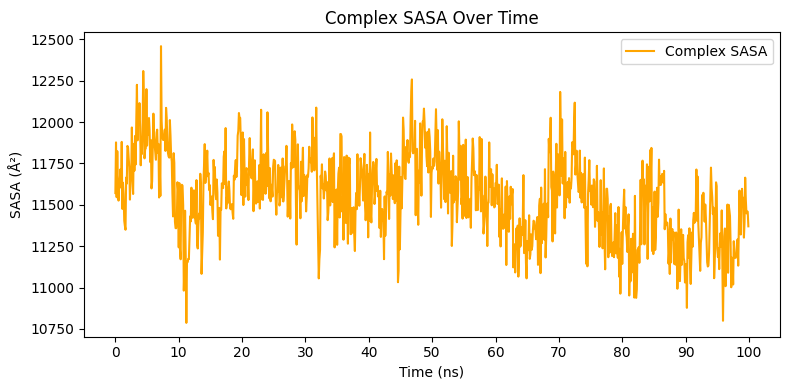

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Convert frame numbers to time (assuming 10 frames = 1 ns)
time_ns = np.array(frames_complex) / 10  # Adjust divisor if needed

plt.figure(figsize=(8, 4))
plt.plot(time_ns, sasa_complex, color='orange', label='Complex SASA')
plt.xlabel("Time (ns)")
plt.ylabel("SASA (Å²)")
plt.title("Complex SASA Over Time")
plt.xticks(np.arange(0, 110, 10))  # X-axis ticks: 0, 10, ..., 100
# Grid removed
plt.legend()
plt.tight_layout()
plt.savefig("/content/95424080R_complex_sasa.png", dpi=1200)
plt.show()

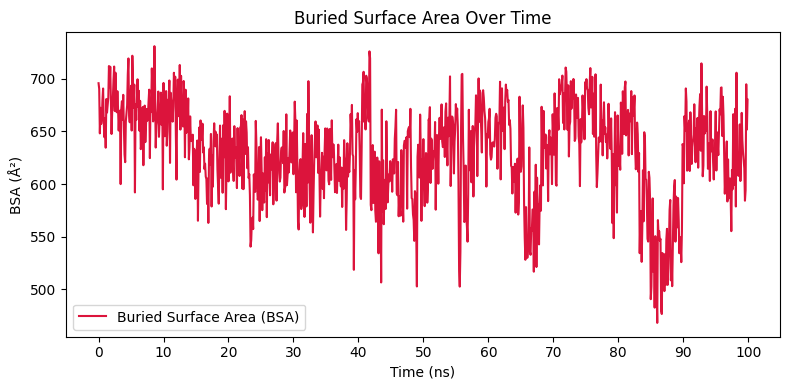

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate BSA
bsa = sasa_protein[:min_len] + sasa_ligand[:min_len] - sasa_complex[:min_len]

# Convert frame numbers to time in ns (assuming stride = 10)
time_ns = np.arange(len(bsa)) / 10  # Adjust divisor if needed

plt.figure(figsize=(8, 4))
plt.plot(time_ns, bsa, color='crimson', label='Buried Surface Area (BSA)')
plt.xlabel("Time (ns)")
plt.ylabel("BSA (Å²)")
plt.title("Buried Surface Area Over Time")
plt.xticks(np.arange(0, 110, 10))  # 0, 10, ..., 100
# Grid removed
plt.legend()
plt.tight_layout()
plt.savefig("/content/95424080R_bsa.png", dpi=1200)
plt.show()


In [57]:
# Ensure numpy is imported
import numpy as np

# Trim all arrays to same length (usually bsa length)
n = len(bsa)

# Calculate means
avg_protein_sasa = np.mean(sasa_protein[:n])
avg_ligand_sasa = np.mean(sasa_ligand[:n])
avg_complex_sasa = np.mean(sasa_complex[:n])
avg_bsa = np.mean(bsa)

# Print results
print(f"Average Protein SASA: {avg_protein_sasa:.2f} Å²")
print(f"Average Ligand SASA: {avg_ligand_sasa:.2f} Å²")
print(f"Average Complex SASA: {avg_complex_sasa:.2f} Å²")
print(f"Average Buried Surface Area (BSA): {avg_bsa:.2f} Å²")


Average Protein SASA: 11722.51 Å²
Average Ligand SASA: 459.96 Å²
Average Complex SASA: 11552.41 Å²
Average Buried Surface Area (BSA): 630.06 Å²


I believe you learnt something new, and I did not waste time.

Please support my work by subscribing to [Bioinformatics Insights](https://youtube.com/@bioinformaticsinsights?si=ExMr3iD26LZYob7Q)